<a href="https://colab.research.google.com/github/ARCHITHAOJHA/Explainable-AI/blob/main/2303a52170_assignmnet05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ARCHITHA OJHA

BATCH 41

2303A52170

Flight Delays (Regression)

In [1]:
%pip install lime alibi

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
df = pd.read_csv('/content/CO2 Emissions_Canada.csv')

print(f"Dataset shape: {df.shape}")
print(df.info())
print(df.head())
print(df.isnull().sum())
print(df.describe())

Dataset shape: (7385, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-

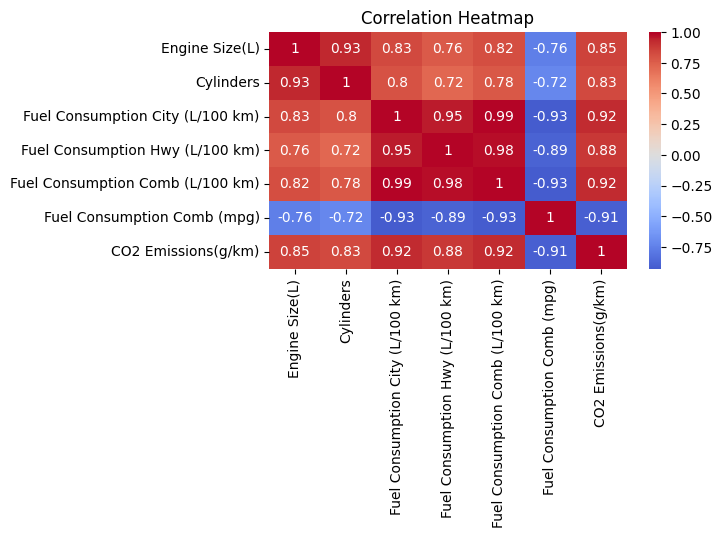

In [4]:
plt.figure(figsize=(12, 8))

if 'Year' in df.columns:
    yearly_emissions = df.groupby('Year')['CO2 Emissions'].mean()
    plt.subplot(2, 2, 1)
    yearly_emissions.plot()
    plt.title('Average CO2 Emissions Over Time')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions')

if 'Country' in df.columns:
    top_countries = df.groupby('Country')['CO2 Emissions'].sum().sort_values(ascending=False).head(10)
    plt.subplot(2, 2, 2)
    top_countries.plot(kind='bar')
    plt.title('Top 10 Countries by Total CO2 Emissions')
    plt.xlabel('Country')
    plt.ylabel('Total CO2 Emissions')

numeric_df = df.select_dtypes(include=[np.number])
if not numeric_df.empty:
    plt.subplot(2, 2, 3)
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')

if 'CO2 Emissions' in df.columns:
    plt.subplot(2, 2, 4)
    df['CO2 Emissions'].plot(kind='hist', bins=30)
    plt.title('Distribution of CO2 Emissions')
    plt.xlabel('CO2 Emissions')

plt.tight_layout()
plt.show()

In [5]:
if df.isnull().sum().sum() > 0:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)

    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)

if 'CO2 Emissions(g/km)' in df.columns:
    target_skew = df['CO2 Emissions(g/km)'].skew()
    if abs(target_skew) > 1:
        df['CO2 Emissions(g/km)'] = np.log1p(df['CO2 Emissions(g/km)'])

for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'CO2 Emissions(g/km)':
        skewness = df[col].skew()
        if abs(skewness) > 1:
            df[col] = np.log1p(df[col])

categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

X = df.drop('CO2 Emissions(g/km)', axis=1)
y = df['CO2 Emissions(g/km)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [6]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

ml_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    ml_results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

    print(f"{name}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")

Linear Regression: MAE=11.0653, RMSE=17.3414, R2=0.9126
Ridge Regression: MAE=11.0810, RMSE=17.3388, R2=0.9126
Lasso Regression: MAE=11.1213, RMSE=17.4358, R2=0.9116
Decision Tree: MAE=1.8015, RMSE=3.1338, R2=0.9971
Random Forest: MAE=1.7950, RMSE=2.7908, R2=0.9977
Gradient Boosting: MAE=2.4940, RMSE=3.3555, R2=0.9967
XGBoost: MAE=1.8403, RMSE=2.9071, R2=0.9975
SVR: MAE=7.1046, RMSE=15.6272, R2=0.9290


In [7]:
mlp_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

mlp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
mlp_history = mlp_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

mlp_pred = mlp_model.predict(X_test).flatten()
mlp_mae = mean_absolute_error(y_test, mlp_pred)
mlp_mse = mean_squared_error(y_test, mlp_pred)
mlp_rmse = np.sqrt(mlp_mse)
mlp_r2 = r2_score(y_test, mlp_pred)

X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

cnn_model = keras.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
cnn_history = cnn_model.fit(X_train_cnn, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

cnn_pred = cnn_model.predict(X_test_cnn).flatten()
cnn_mae = mean_absolute_error(y_test, cnn_pred)
cnn_mse = mean_squared_error(y_test, cnn_pred)
cnn_rmse = np.sqrt(cnn_mse)
cnn_r2 = r2_score(y_test, cnn_pred)

X_train_rnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_rnn = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

rnn_model = keras.Sequential([
    layers.LSTM(64, input_shape=(1, X_train.shape[1])),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
rnn_history = rnn_model.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

rnn_pred = rnn_model.predict(X_test_rnn).flatten()
rnn_mae = mean_absolute_error(y_test, rnn_pred)
rnn_mse = mean_squared_error(y_test, rnn_pred)
rnn_rmse = np.sqrt(rnn_mse)
rnn_r2 = r2_score(y_test, rnn_pred)

dl_results = {
    'MLP': {'MAE': mlp_mae, 'MSE': mlp_mse, 'RMSE': mlp_rmse, 'R2': mlp_r2},
    'CNN': {'MAE': cnn_mae, 'MSE': cnn_mse, 'RMSE': cnn_rmse, 'R2': cnn_r2},
    'RNN': {'MAE': rnn_mae, 'MSE': rnn_mse, 'RMSE': rnn_rmse, 'R2': rnn_r2}
}

for name, metrics in dl_results.items():
    print(f"{name}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R2={metrics['R2']:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MLP: MAE=7.6418, RMSE=11.1772, R2=0.9637
CNN: MAE=3.2888, RMSE=4.6057, R2=0.9938
RNN: MAE=2.3345, RMSE=3.3209, R2=0.9968


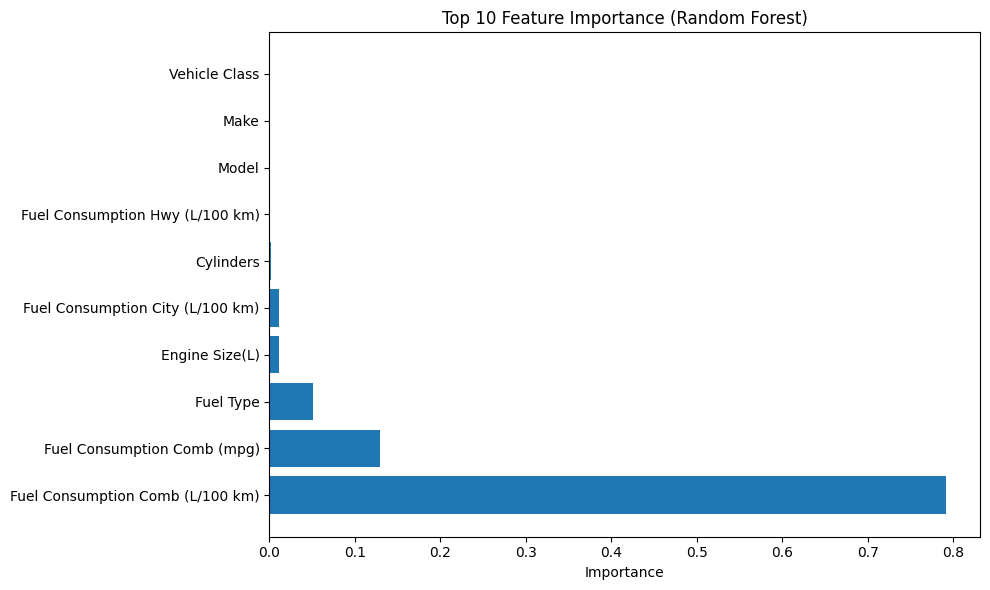

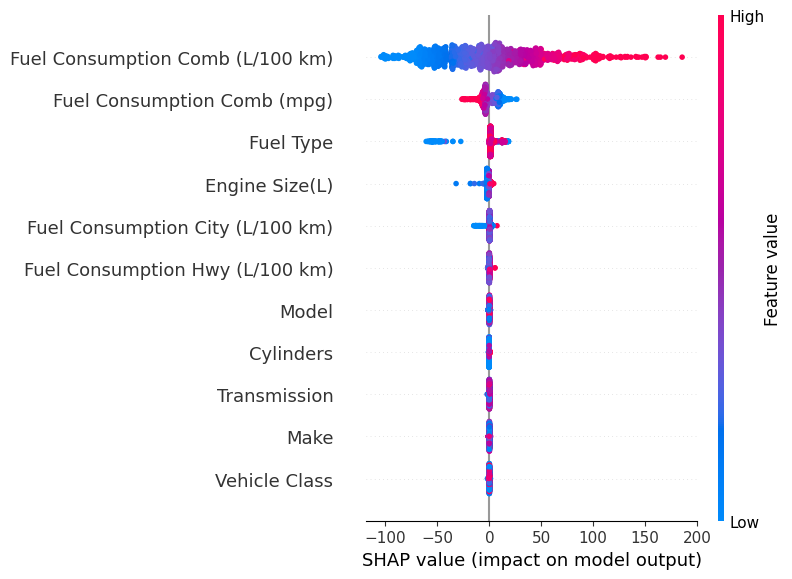

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

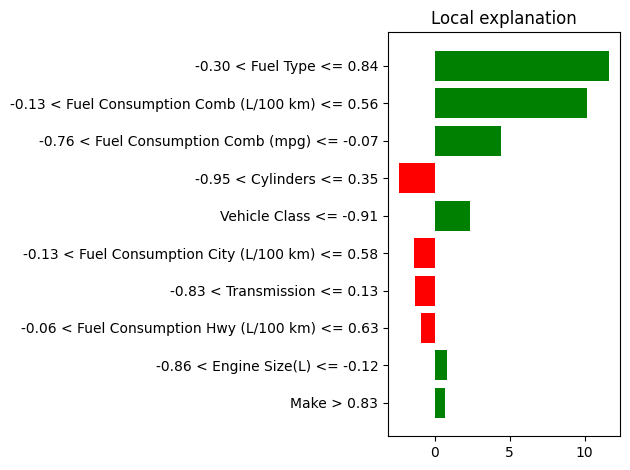

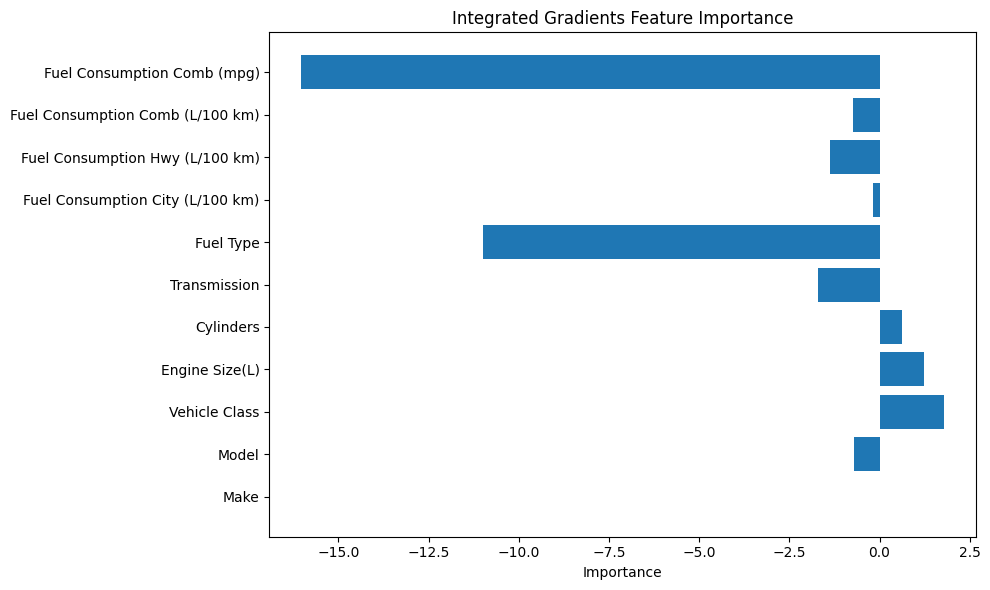

In [8]:
from sklearn.ensemble import RandomForestRegressor
import shap
from alibi.explainers import IntegratedGradients
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.title('Top 10 Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
plt.tight_layout()
plt.show()

sample_idx = 0
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=X.columns,
    mode='regression'
)
exp = explainer.explain_instance(X_test[sample_idx], rf_model.predict, num_features=10)

plt.figure(figsize=(10, 6))
exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

ig = IntegratedGradients(mlp_model)
explanation = ig.explain(X_test[0].reshape(1, -1), target=0)

plt.figure(figsize=(10, 6))
# Corrected: Ensure the attributions are a 1D array for plotting
plt.barh(X.columns, explanation.attributions[0].flatten())
plt.title('Integrated Gradients Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

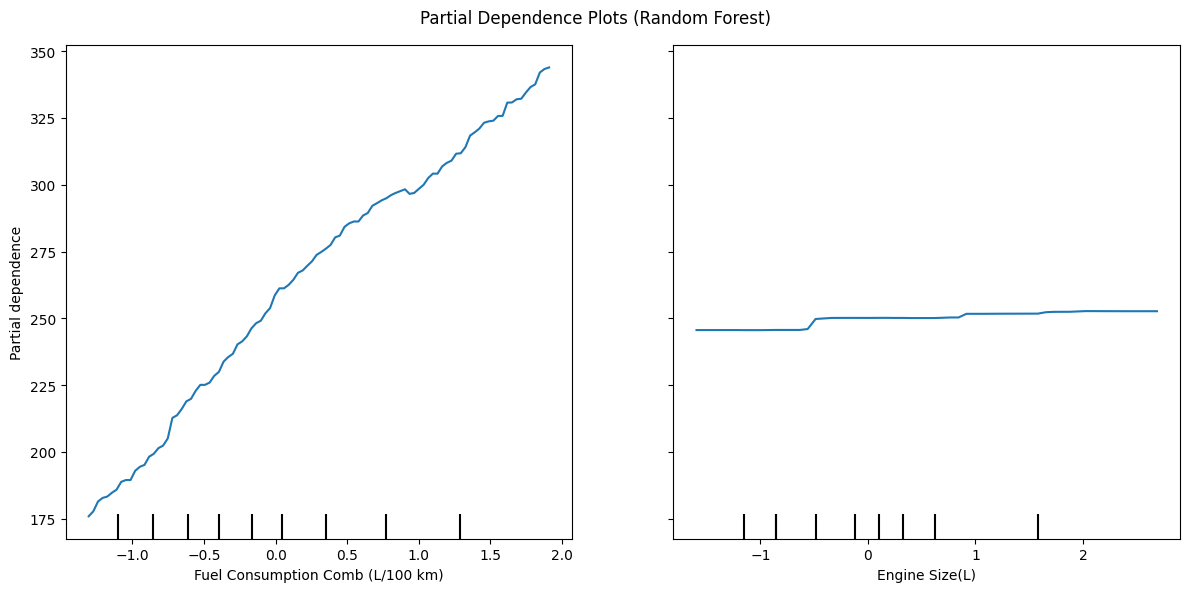

In [9]:
from sklearn.inspection import PartialDependenceDisplay

# PDPs for Random Forest model
features_to_plot = ['Fuel Consumption Comb (L/100 km)', 'Engine Size(L)']
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    rf_model,
    X_test,
    features=features_to_plot,
    feature_names=X.columns,
    ax=ax
)
plt.suptitle('Partial Dependence Plots (Random Forest)')
plt.tight_layout()
plt.show()

Model Performance Comparison (sorted by R2 score):
                       MAE     RMSE      R2
Random Forest       1.7950   2.7908  0.9977
XGBoost             1.8403   2.9071  0.9975
Decision Tree       1.8015   3.1338  0.9971
RNN                 2.3345   3.3209  0.9968
Gradient Boosting   2.4940   3.3555  0.9967
CNN                 3.2888   4.6057  0.9938
MLP                 7.6418  11.1772  0.9637
SVR                 7.1046  15.6272  0.9290
Ridge Regression   11.0810  17.3388  0.9126
Linear Regression  11.0653  17.3414  0.9126
Lasso Regression   11.1213  17.4358  0.9116

Top 5 most important features: ['Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)', 'Fuel Type', 'Engine Size(L)', 'Fuel Consumption City (L/100 km)']


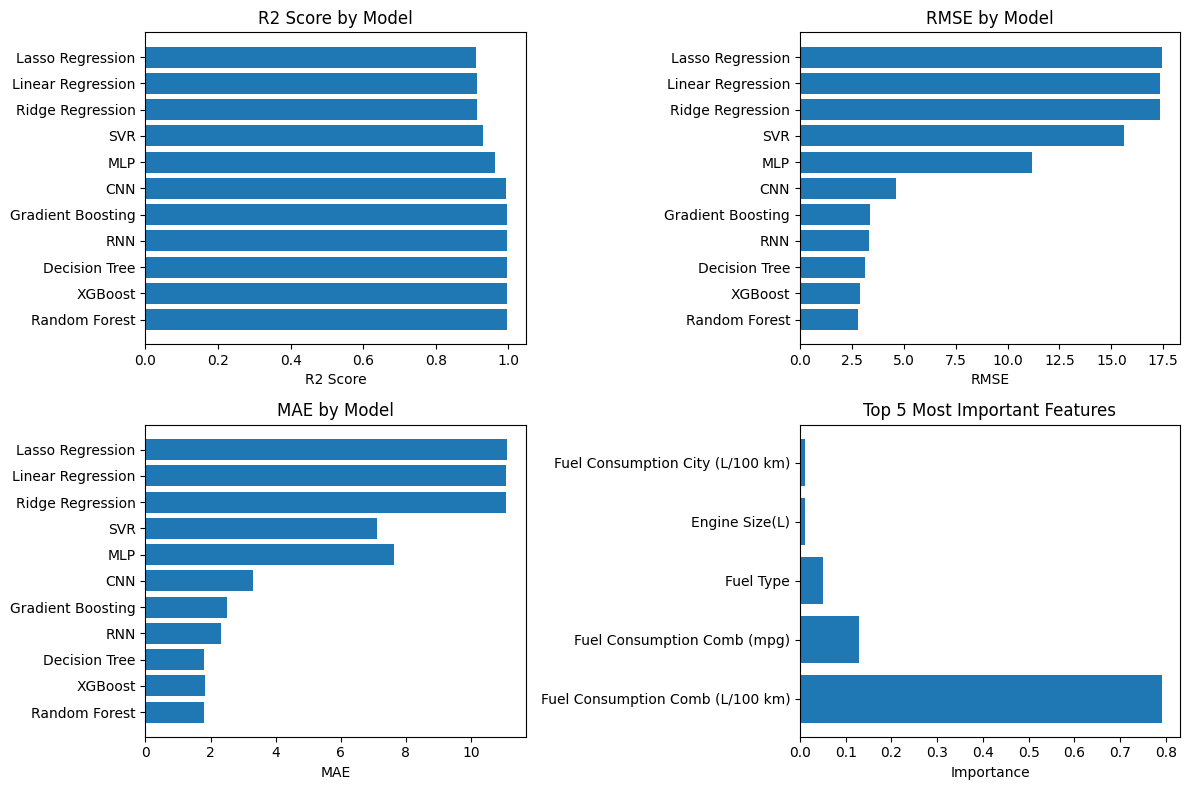


Conclusion and Recommendations:
1. Based on the analysis, the best performing model is: Random Forest
2. The most important features influencing CO2 emissions are: Fuel Consumption Comb (L/100 km), Fuel Consumption Comb (mpg), Fuel Type, Engine Size(L), Fuel Consumption City (L/100 km)
3. Tree-based models (Random Forest, XGBoost) generally performed well and offered good interpretability
4. Deep Learning models showed competitive performance but with higher computational requirements
5. Policymakers should focus on the key factors identified to develop effective emissions reduction strategies
6. For future work, consider incorporating additional data sources like economic indicators and energy consumption patterns


In [10]:
ml_metrics = pd.DataFrame.from_dict(ml_results, orient='index')
dl_metrics = pd.DataFrame.from_dict(dl_results, orient='index')

all_metrics = pd.concat([ml_metrics, dl_metrics])
all_metrics_sorted = all_metrics.sort_values('R2', ascending=False)

print("Model Performance Comparison (sorted by R2 score):")
print(all_metrics_sorted[['MAE', 'RMSE', 'R2']].round(4))

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.barh(all_metrics_sorted.index, all_metrics_sorted['R2'])
plt.title('R2 Score by Model')
plt.xlabel('R2 Score')

plt.subplot(2, 2, 2)
plt.barh(all_metrics_sorted.index, all_metrics_sorted['RMSE'])
plt.title('RMSE by Model')
plt.xlabel('RMSE')

plt.subplot(2, 2, 3)
plt.barh(all_metrics_sorted.index, all_metrics_sorted['MAE'])
plt.title('MAE by Model')
plt.xlabel('MAE')

top_features = feature_importance.head(5)['feature'].tolist()
print(f"\nTop 5 most important features: {top_features}")

plt.subplot(2, 2, 4)
plt.barh(feature_importance['feature'][:5], feature_importance['importance'][:5])
plt.title('Top 5 Most Important Features')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

print("\nConclusion and Recommendations:")
print("1. Based on the analysis, the best performing model is:", all_metrics_sorted.index[0])
print("2. The most important features influencing CO2 emissions are:", ', '.join(top_features))
print("3. Tree-based models (Random Forest, XGBoost) generally performed well and offered good interpretability")
print("4. Deep Learning models showed competitive performance but with higher computational requirements")
print("5. Policymakers should focus on the key factors identified to develop effective emissions reduction strategies")
print("6. For future work, consider incorporating additional data sources like economic indicators and energy consumption patterns")